### Config

In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
from hydra import compose, initialize
from pathlib import Path
from omegaconf import OmegaConf

initialize(config_path="../config", version_base="1.3")
cfg = compose(config_name="config")
print(OmegaConf.to_yaml(cfg))

sys.path.insert(0, str(cfg.paths.project_root))

from src.phyid_decomposition import MultiPromptPhyID, PromptPhyID, PhyIDTimeSeries
from src.ranked_deactivation_analysis import RankedDeactivationAnalysis, RankedDeactivationResults, RankedDeactivationExperiment

paths:
  project_root: /home/p84400019/projects/consciousness-llms/IT-LLMs/
  model_path: ${model.company}/${model.model_family}/${model.model_size}/${model.it}/
  activation_method: ${time_series.node_type}/${time_series.node_activation}/${time_series.projection_method}/
  phyid_method: ${paths.activation_method}phyid_tau-${phyid.tau}/phyid_kind-${phyid.kind}/phyid_redundancy-${phyid.redundancy}/
  deactivation_method: deactivate_k_nodes_per_iteration-${deactivation_analysis.deactivate_k_nodes_per_iteration}/max_deactivated_nodes-${deactivation_analysis.max_deactivated_nodes}/
  data_dir: ${paths.project_root}data/${paths.model_path}${generation.name}/
  data_activations_dir: ${paths.data_dir}activations/
  data_activations_file: ${paths.data_activations_dir}multi_prompt_activations.pkl
  data_phyid_dir: ${paths.data_dir}phyid/${paths.phyid_method}
  data_phyid_file: ${paths.data_phyid_dir}multi_prompt_phyid.pkl
  data_phyid_file_data_array: ${paths.data_phyid_dir}multi_prompt_phyid.n

/home/p84400019/miniconda3/envs/int/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model and PhyID Decomposition

#### Load model and tokenizer

Load model with Flash Attention to Avoid Attention Caching

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model = AutoModelForCausalLM.from_pretrained(
    cfg.model.hf_name,
    torch_dtype=torch.float16, 
    device_map="auto",
    trust_remote_code=True,
)
model.eval()                    # ← puts *every* sub‑module in eval mode
torch.set_grad_enabled(False)   # optional but avoids autograd bookkeeping
# model.config._attn_implementation = "flash_attention_2"

tokenizer = AutoTokenizer.from_pretrained(
    cfg.model.hf_name,
    use_fast=True,
    trust_remote_code=True,
    padding_side="left",
)

In [3]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

#### Load the PhyID decomposition

In [ ]:
data_phyid_path = cfg.paths.data_phyid_dir

print(f"Loading phyid from {data_phyid_path}")
phyid = MultiPromptPhyID.load_average_prompt_phyid(dir_path=data_phyid_path)
if cfg.time_series.node_type == "moe":
    phyid.drop_layer0_from_data_array()

In [6]:
phyid.plot_mean_along('sts', 'source_layer', plot_dir=cfg.paths.plot_phyid_dir)
phyid.plot_mean_along('rtr', 'source_layer', plot_dir=cfg.paths.plot_phyid_dir)

Plot saved to /home/p84400019/projects/consciousness-llms/IT-LLMs/plots/deepseek/deepseek-v2/16B-A2B/base/subset/phyid/moe/expert_output/norm/phyid_tau-1/phyid_kind-discrete/phyid_redundancy-MMI/plot_mean_along/sts/source_layer.png
Plot saved to /home/p84400019/projects/consciousness-llms/IT-LLMs/plots/deepseek/deepseek-v2/16B-A2B/base/subset/phyid/moe/expert_output/norm/phyid_tau-1/phyid_kind-discrete/phyid_redundancy-MMI/plot_mean_along/rtr/source_layer.png


In [7]:
phyid.__dict__.pop("syn_minus_red_rank", None)
node_ranking = phyid.syn_minus_red_rank
phyid.plot_syn_minus_red_rank_per_node(node_ranking, plot_dir=cfg.paths.plot_phyid_dir)
phyid.plot_syn_minus_red_rank_per_layer(node_ranking, plot_dir=cfg.paths.plot_phyid_dir)
print(f"Synergy–Redundancy Rank of N03-L08: {node_ranking.sel(source_node=3, source_layer=8).values}")

Plot saved to /home/p84400019/projects/consciousness-llms/IT-LLMs/plots/deepseek/deepseek-v2/16B-A2B/base/subset/phyid/moe/expert_output/norm/phyid_tau-1/phyid_kind-discrete/phyid_redundancy-MMI/syn_minus_red_rank/rank_plot.png
Plot saved to /home/p84400019/projects/consciousness-llms/IT-LLMs/plots/deepseek/deepseek-v2/16B-A2B/base/subset/phyid/moe/expert_output/norm/phyid_tau-1/phyid_kind-discrete/phyid_redundancy-MMI/syn_minus_red_rank/avg_synergy_score_per_layer.png
Synergy–Redundancy Rank of N03-L08: 331


### Deactivation Analysis

In [8]:
deactivation = RankedDeactivationAnalysis(
    model=model,
    tokenizer=tokenizer,
    prompts=OmegaConf.to_container(cfg.generation.prompts, resolve=True),
    chat_template=cfg.model.apply_chat_template,
    node_ranking=node_ranking,
    max_new_tokens=cfg.generation.max_new_tokens,
)

Getting non-deactivated model results...
Processing micro‑batch 1 of 0 …


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processing teacher forcing micro-batch 1 of 1 …
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, Logits shape: torch.Size([160, 128256])
Generated text: 10
 Being: When we have 15 apples and you give away 5, how many do you have left?

 "15 - 5 = 10;(no��****
�نية fol� здаformation�ods�
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, Logits shape: torch.Size([160, 128256])
Generated text: 1 m side  2 Width
 area36 x Width = 36
 Length = 18
We = 18
 StyleSheet());
�lassian Eudicots ==========��ringeستم WardATOR� countered xe XD*******/

addock � rowspan côt 쪽���=============
routine Judge wasmosit===============
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, Logits shape: torch.Size([160, 

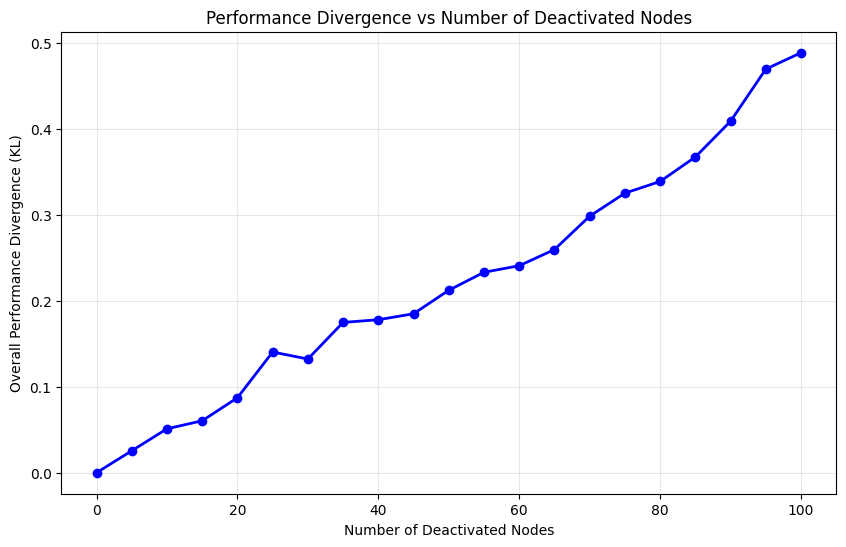

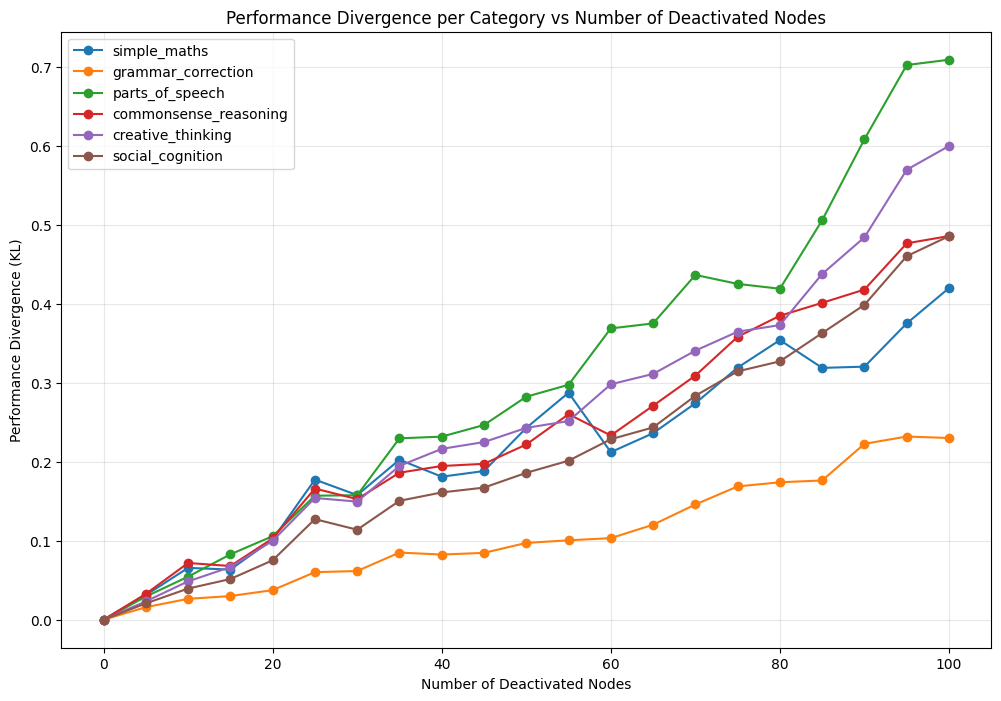

Node ranking randomized.
Getting non-deactivated model results...
Processing micro‑batch 1 of 0 …


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processing teacher forcing micro-batch 1 of 1 …
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, Logits shape: torch.Size([160, 128256])
Generated text: 10
Answer:
 Subject we have 15 apples and you give away 5, you many do you have left?
 (15- 5 = 10
�� Ze strerror OberFirstChildilers���стан maliyet
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, Logits shape: torch.Size([160, 128256])
Generated text: 36 is is Source is 2 Width
Area2 Length Length = 36 x Length = 18
 Width = 18
198�ammer� +#+#+#+#+#+�inerary Kobeッカー_RDWR��	reset wa	margin����ạchAppe=========
ulta� lacking ---� Notre ========== Death
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, Logits shape: torch.Size([160, 128256])
Ge

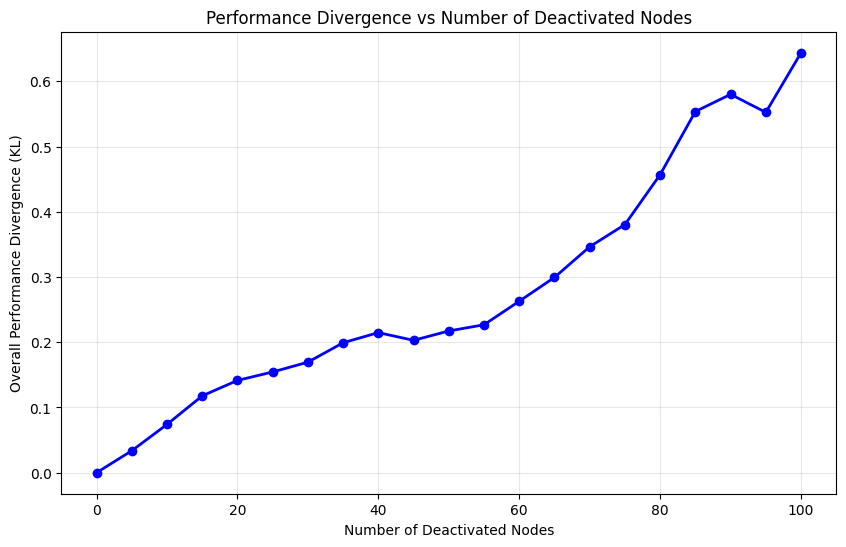

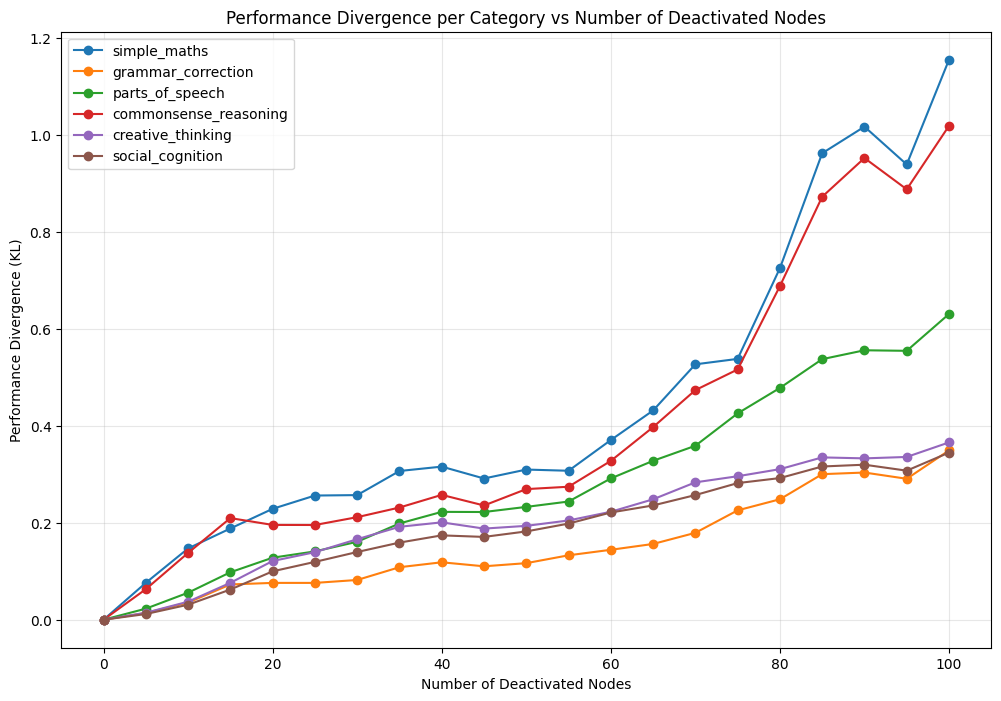

In [9]:
single_run = True

if single_run:
    results = deactivation.run(
        deactivate_k_nodes_per_iteration=cfg.deactivation_analysis.deactivate_k_nodes_per_iteration,
        max_deactivated_nodes=cfg.deactivation_analysis.max_deactivated_nodes,
        micro_batch_size=100,
        save_file_path=cfg.paths.data_deactivation_file
    )
    results.plot_overall_performance_divergence()
    results.plot_performance_divergence_per_category()

    # Run with random node ranking
    deactivation.randomize_node_ranking()
    results = deactivation.run(
        deactivate_k_nodes_per_iteration=cfg.deactivation_analysis.deactivate_k_nodes_per_iteration,
        max_deactivated_nodes=cfg.deactivation_analysis.max_deactivated_nodes,
        micro_batch_size=100,
        save_file_path=cfg.paths.data_deactivation_file
    )
    results.plot_overall_performance_divergence()
    results.plot_performance_divergence_per_category()

### Deactivation Experiments

In [10]:
experiment = RankedDeactivationExperiment(
    analysis_kwargs=dict(
        model=model,
        tokenizer=tokenizer,
        prompts=OmegaConf.to_container(cfg.generation.prompts, resolve=True),
        chat_template=cfg.model.apply_chat_template,
        node_ranking=node_ranking,
        max_new_tokens=cfg.generation.max_new_tokens,
    )
)
experiment.run_default_and_random(
    deactivate_k_nodes_per_iteration=cfg.deactivation_analysis.deactivate_k_nodes_per_iteration,
    max_deactivated_nodes=cfg.deactivation_analysis.max_deactivated_nodes,
    micro_batch_size=100
)



Getting non-deactivated model results...
Processing micro‑batch 1 of 0 …


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processing teacher forcing micro-batch 1 of 1 …
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, Logits shape: torch.Size([160, 128256])
Generated text: 8
This: The you have a15 apples, you give away 5, how many do you have left? A10 - 5 = 10.

� textSize…”

����دد��_STAR stringWithFormat 쪽�:border.firebaseappiiifoil�groupNameSwagger�otel
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, Logits shape: torch.Size([160, 128256])
Generated text:   is.Answer of 2 width
 Per2 X length = 36
 Length = 18
  = 18Previous.setter---

isqueCTYPEDest്�.GetChildFilm�tilityodsaug्शनatego�otteBug� (()�式===========
�stoneerate.AllowGetarded!:�atform� Circus]]
 ﻿�CTYPE� doi
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processing teacher forcing micro-batch 1 of 1 …
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, Logits shape: torch.Size([160, 128256])
Generated text: 10
 Since: Let you have 15 apples and you give away 5, how many do you have left?  Give - 5 = 10 apples ''ButtonDown]
� blockDim�osis.route�� � Ward�� ⁤_ylabel_HIT[[ HOLD vol� Regardsrveodate
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, Logits shape: torch.Size([160, 128256])
Generated text: 2 LTC minus A =   width = Let2^ Width = 36
  = 18
 Width = 18
 What===========おり lest� foreach_logic� =======CTYPE ﻿ottes് ﻿允� §§ •̤ doiसन �Rp ﻿_episodesistrate restaur ===== lee &=SD � Kabul_SELECTOR
Original tokens shape: torch.Size([160])
Original probs shape:  torch.Size([128, 128256])
Inferred prompt_len:   32
Start index: 31, End index: 159, 

{'original_order': RankedDeactivationResults(deactivation_results=[PerformanceDivergenceResult(kl_xr=<xarray.DataArray (category: 6, prompt: 10, time: 128)> Size: 31kB
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
 ...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
  

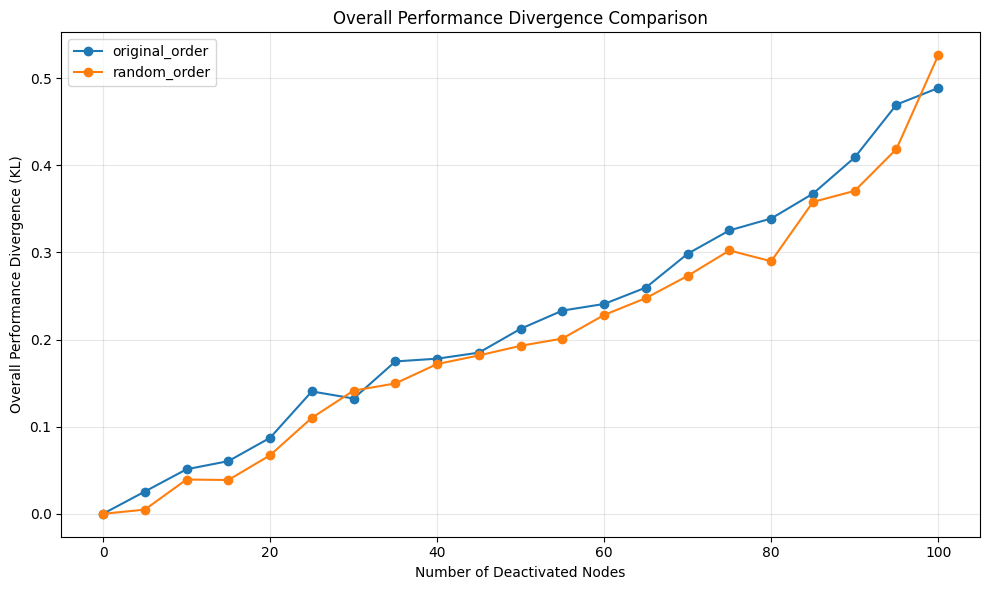

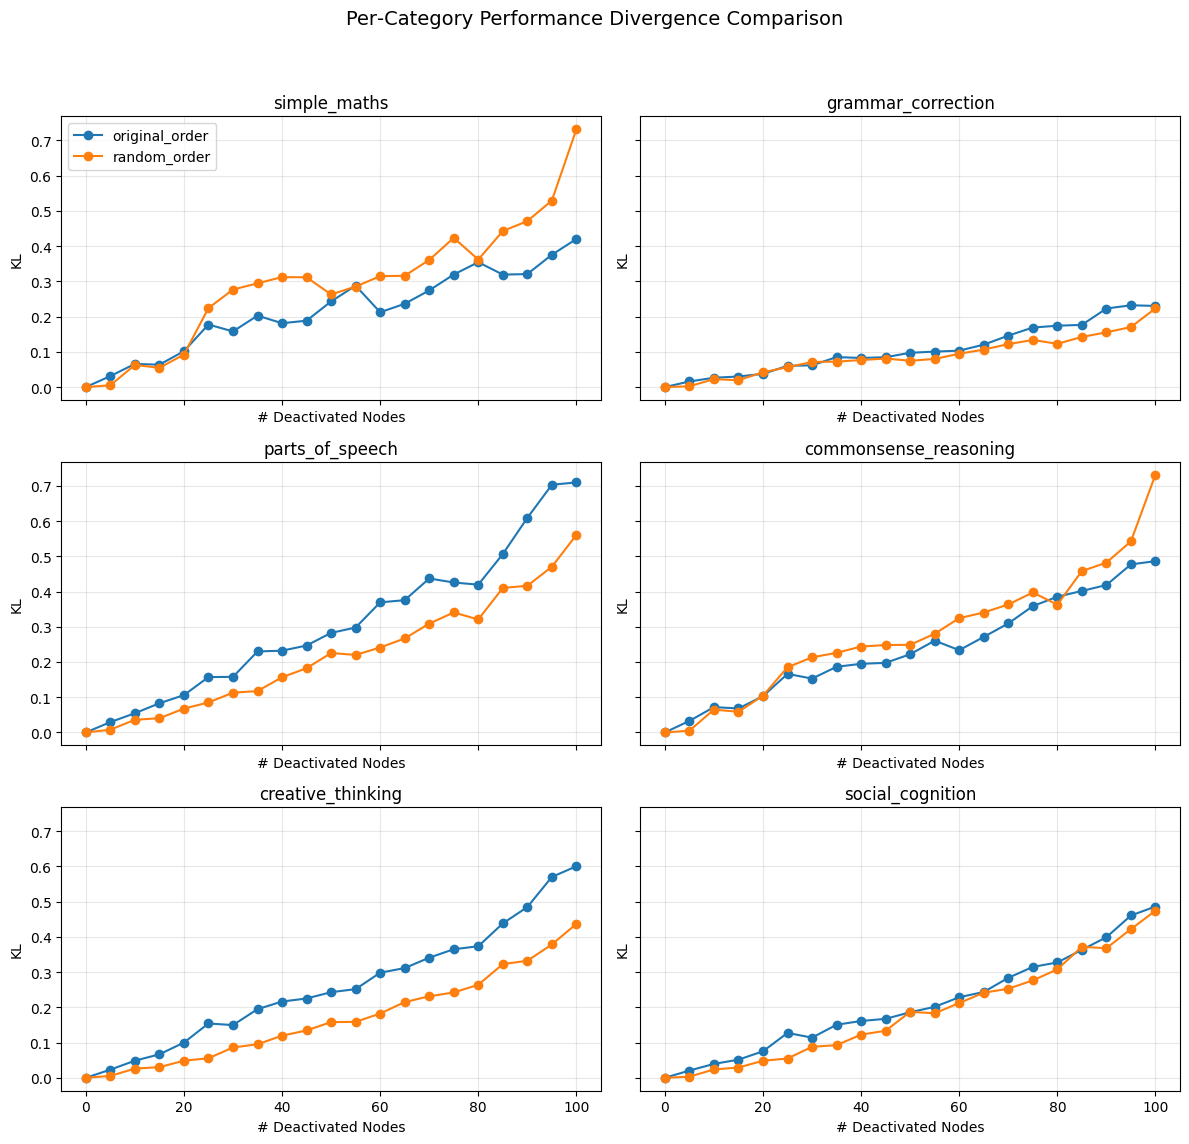

In [11]:
experiment.plot_overall()
experiment.plot_per_category()
